In [1]:
#pip install pydotplus

In [2]:
#pip install skompiler

In [3]:
#pip install astor

In [4]:
#pip install graphviz

In [5]:
################################################
# Decision Tree Classification: CART
################################################

import warnings
import joblib
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from skompiler import skompile
import graphviz

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

In [6]:
################################################
# 1. Modeling using CART
################################################

df = pd.read_csv("datasets/diabetes.csv")

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [7]:
cart_model = DecisionTreeClassifier(random_state=1).fit(X, y)

In [8]:
# Confusion matrix için y_pred:
y_pred = cart_model.predict(X)

# AUC için y_prob:
y_prob = cart_model.predict_proba(X)[:, 1]

# Confusion matrix
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       268

    accuracy                           1.00       768
   macro avg       1.00      1.00      1.00       768
weighted avg       1.00      1.00      1.00       768



In [9]:
# AUC
roc_auc_score(y, y_prob)

1.0

In [10]:
#####################
# Holdout Yöntemi ile Başarı Değerlendirme
#####################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=45)

cart_model = DecisionTreeClassifier(random_state=17).fit(X_train, y_train)

In [11]:
# Train Hatası
y_pred = cart_model.predict(X_train)
y_prob = cart_model.predict_proba(X_train)[:, 1]
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       346
           1       1.00      1.00      1.00       191

    accuracy                           1.00       537
   macro avg       1.00      1.00      1.00       537
weighted avg       1.00      1.00      1.00       537



In [12]:
roc_auc_score(y_train, y_prob)

1.0

In [13]:
# Test Hatası
y_pred = cart_model.predict(X_test)
y_prob = cart_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       154
           1       0.53      0.56      0.54        77

    accuracy                           0.69       231
   macro avg       0.65      0.66      0.65       231
weighted avg       0.69      0.69      0.69       231



In [14]:
roc_auc_score(y_test, y_prob)

0.6558441558441559

In [15]:
#####################
# CV ile Başarı Değerlendirme
#####################

cart_model = DecisionTreeClassifier(random_state=17).fit(X, y)

cv_results = cross_validate(cart_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

0.7058568882098294

In [16]:
cv_results['test_f1'].mean()

0.5710621194523633

In [17]:
cv_results['test_roc_auc'].mean()

0.6719440950384347

In [18]:
################################################
# 2. Hyperparameter Optimization with GridSearchCV
################################################

cart_model.get_params()

cart_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20)}

cart_best_grid = GridSearchCV(cart_model,
                              cart_params,
                              cv=5,
                              n_jobs=-1,
                              verbose=1).fit(X, y)

cart_best_grid.best_params_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


{'max_depth': 5, 'min_samples_split': 4}

In [19]:
cart_best_grid.best_score_

0.7500806383159324

In [20]:
random = X.sample(1, random_state=45)

print(cart_best_grid.predict(random))

[1]


In [21]:
################################################
# 3. Final Model
################################################

cart_final = DecisionTreeClassifier(**cart_best_grid.best_params_, random_state=17).fit(X, y)
cart_final.get_params()

cart_final = cart_model.set_params(**cart_best_grid.best_params_).fit(X, y)

In [22]:
cv_results = cross_validate(cart_final,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

0.7500806383159324

In [23]:
cv_results['test_f1'].mean()

0.614625004082526

In [24]:
cv_results['test_roc_auc'].mean()

0.797796645702306

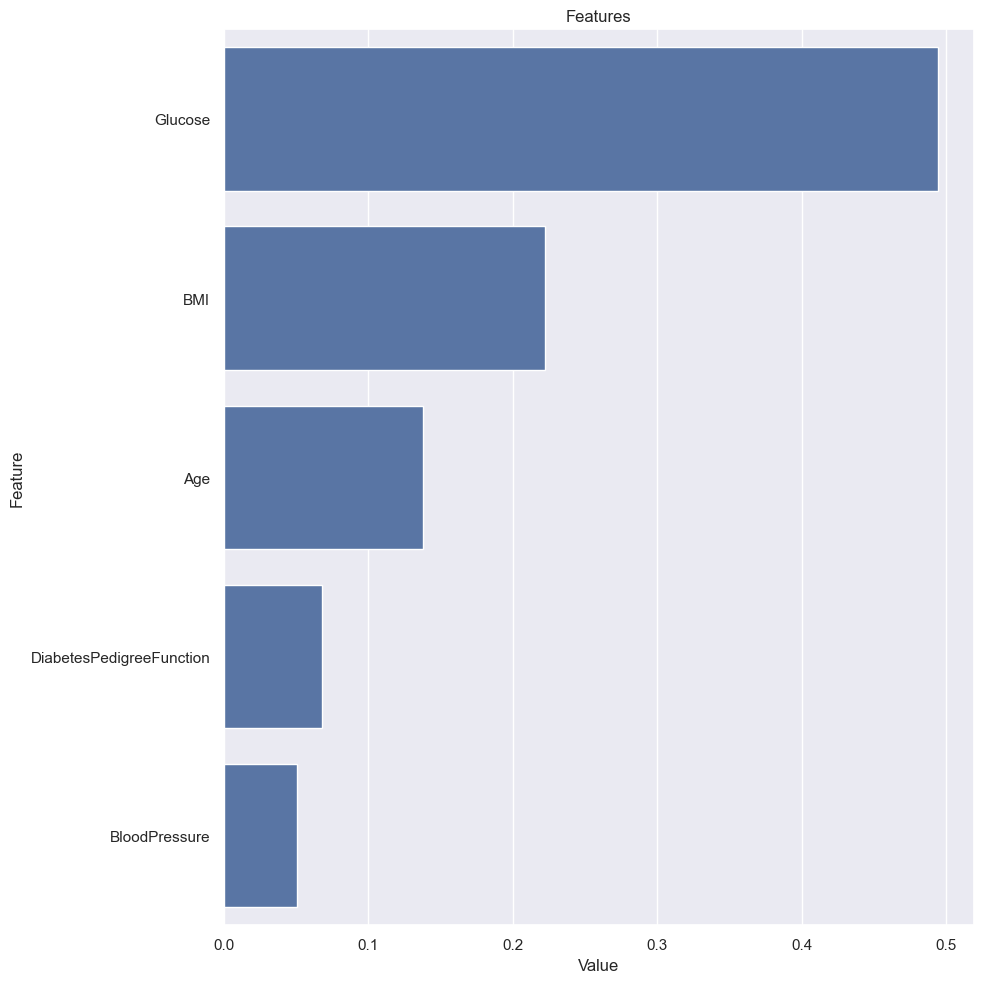

In [25]:
################################################
# 4. Feature Importance
################################################

cart_final.feature_importances_

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(cart_final, X, num=5)

In [26]:
################################################
# 5. Analyzing Model Complexity with Learning Curves (BONUS)
################################################


train_score, test_score = validation_curve(cart_final, X, y,
                                           param_name="max_depth",
                                           param_range=range(1, 11),
                                           scoring="roc_auc",
                                           cv=10)

mean_train_score = np.mean(train_score, axis=1)
mean_train_score

array([0.70729413, 0.78976751, 0.83642714, 0.87603684, 0.90819184,
       0.93528351, 0.96013549, 0.97716774, 0.98781586, 0.99359846])

In [27]:
mean_test_score = np.mean(test_score, axis=1)
mean_test_score

array([0.68127066, 0.74061681, 0.77597863, 0.77651852, 0.77109259,
       0.76239744, 0.74034473, 0.7137265 , 0.69966524, 0.69232051])

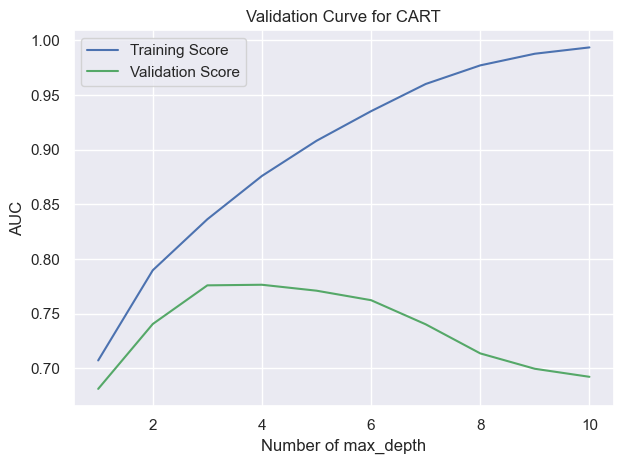

In [28]:
plt.plot(range(1, 11), mean_train_score,
         label="Training Score", color='b')

plt.plot(range(1, 11), mean_test_score,
         label="Validation Score", color='g')

plt.title("Validation Curve for CART")
plt.xlabel("Number of max_depth")
plt.ylabel("AUC")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

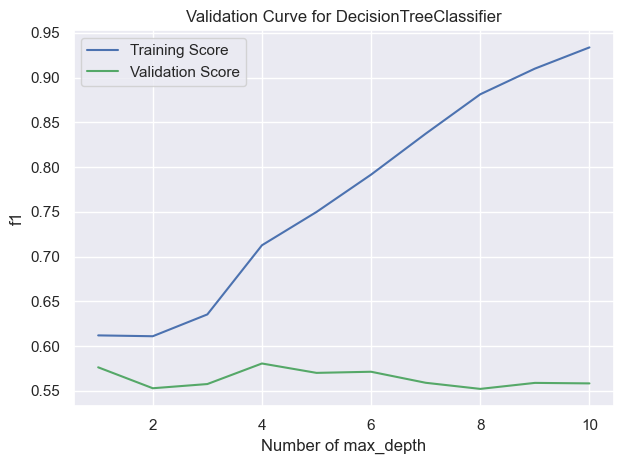

In [29]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)


val_curve_params(cart_final, X, y, "max_depth", range(1, 11), scoring="f1")

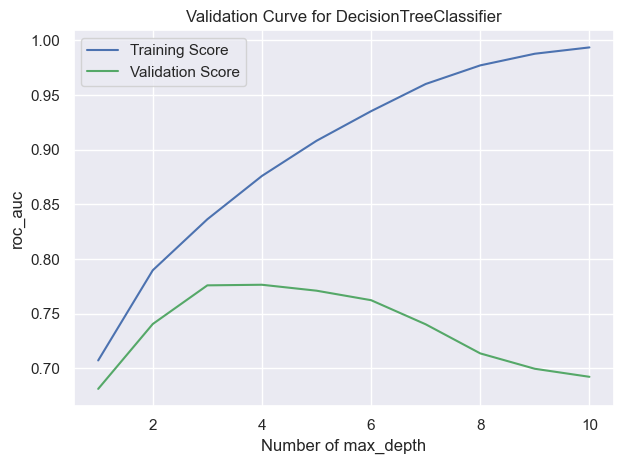

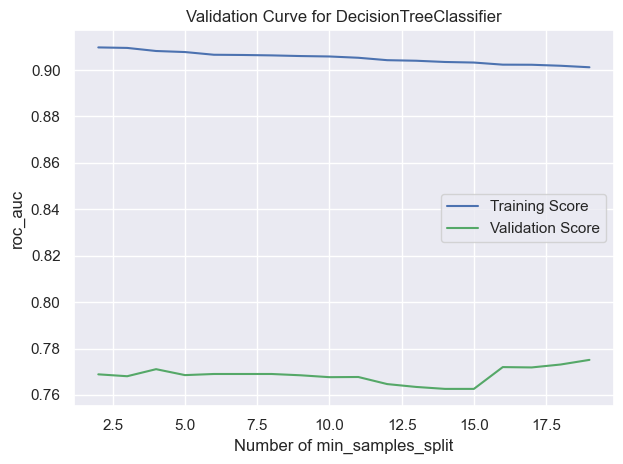

In [30]:
cart_val_params = [["max_depth", range(1, 11)], ["min_samples_split", range(2, 20)]]

for i in range(len(cart_val_params)):
    val_curve_params(cart_model, X, y, cart_val_params[i][0], cart_val_params[i][1])

In [31]:
################################################
# 6. Visualizing the Decision Tree
################################################

def tree_graph(model, col_names, file_name):
    tree_str = export_graphviz(model, feature_names=col_names, filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(file_name)


tree_graph(model=cart_final, col_names=X.columns, file_name="cart_final.png")

In [32]:
cart_final.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 17,
 'splitter': 'best'}

In [33]:
################################################
# 7. Extracting Decision Rules
################################################

tree_rules = export_text(cart_final, feature_names=list(X.columns))
print(tree_rules)

|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 45.40
|   |   |   |--- BMI <= 30.95
|   |   |   |   |--- Pregnancies <= 7.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Pregnancies >  7.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- BMI >  30.95
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- DiabetesPedigreeFunction >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- BMI >  45.40
|   |   |   |--- BloodPressure <= 99.00
|   |   |   |   |--- class: 1
|   |   |   |--- BloodPressure >  99.00
|   |   |   |   |--- class: 0
|   |--- Age >  28.50
|   |   |--- BMI <= 26.35
|   |   |   |--- BMI <= 9.65
|   |   |   |   |--- class: 1
|   |   |   |--- BMI >  9.65
|   |   |   |   |--- class: 0
|   |   |--- BMI >  26.35
|   |   |   |--- Glucose <= 99.50
|   |   |   |   |--- Glucose <= 28.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Glucose >  28.50
|   |   |   |   |   |--- class: 0
|   |  

In [34]:
################################################
# 8. Extracting Python Codes of Decision Rules
################################################

# sklearn '0.23.1' versiyonu ile yapılabilir.
# pip install scikit-learn==0.23.1

print(skompile(cart_final.predict).to('python/code'))

print(skompile(cart_final.predict).to('sqlalchemy/sqlite'))

print(skompile(cart_final.predict).to('excel'))

(((((0 if x[0] <= 7.5 else 1) if x[5] <= 30.949999809265137 else 0 if x[6] <=
    0.5005000084638596 else 0) if x[5] <= 45.39999961853027 else 1 if x[2] <=
    99.0 else 0) if x[7] <= 28.5 else (1 if x[5] <= 9.649999618530273 else 
    0) if x[5] <= 26.350000381469727 else (1 if x[1] <= 28.5 else 0) if x[1
    ] <= 99.5 else 0 if x[6] <= 0.5609999895095825 else 1) if x[1] <= 127.5
     else (((0 if x[5] <= 28.149999618530273 else 1) if x[4] <= 132.5 else 
    0) if x[1] <= 145.5 else 0 if x[7] <= 25.5 else 1 if x[7] <= 61.0 else 
    0) if x[5] <= 29.949999809265137 else ((1 if x[2] <= 61.0 else 0) if x[
    7] <= 30.5 else 1 if x[6] <= 0.4294999986886978 else 1) if x[1] <= 
    157.5 else (1 if x[6] <= 0.3004999905824661 else 1) if x[4] <= 629.5 else 0
    )



ModuleNotFoundError: No module named 'sqlalchemy'

In [35]:
################################################
# 9. Prediction using Python Codes
################################################

def predict_with_rules(x):
    return ((((((0 if x[6] <= 0.671999990940094 else 1 if x[6] <= 0.6864999830722809 else
        0) if x[0] <= 7.5 else 1) if x[5] <= 30.949999809265137 else ((1 if x[5
        ] <= 32.45000076293945 else 1 if x[3] <= 10.5 else 0) if x[2] <= 53.0 else
        ((0 if x[1] <= 111.5 else 0 if x[2] <= 72.0 else 1 if x[3] <= 31.0 else
        0) if x[2] <= 82.5 else 1) if x[4] <= 36.5 else 0) if x[6] <=
        0.5005000084638596 else (0 if x[1] <= 88.5 else (((0 if x[0] <= 1.0 else
        1) if x[1] <= 98.5 else 1) if x[6] <= 0.9269999861717224 else 0) if x[1
        ] <= 116.0 else 0 if x[4] <= 166.0 else 1) if x[2] <= 69.0 else ((0 if
        x[2] <= 79.0 else 0 if x[1] <= 104.5 else 1) if x[3] <= 5.5 else 0) if
        x[6] <= 1.098000019788742 else 1) if x[5] <= 45.39999961853027 else 0 if
        x[7] <= 22.5 else 1) if x[7] <= 28.5 else (1 if x[5] <=
        9.649999618530273 else 0) if x[5] <= 26.350000381469727 else (1 if x[1] <=
        28.5 else ((0 if x[0] <= 11.5 else 1 if x[5] <= 31.25 else 0) if x[1] <=
        94.5 else (1 if x[5] <= 36.19999885559082 else 0) if x[1] <= 97.5 else
        0) if x[6] <= 0.7960000038146973 else 0 if x[0] <= 3.0 else (1 if x[6] <=
        0.9614999890327454 else 0) if x[3] <= 20.0 else 1) if x[1] <= 99.5 else
        ((1 if x[5] <= 27.649999618530273 else 0 if x[0] <= 5.5 else (((1 if x[
        0] <= 7.0 else 0) if x[1] <= 103.5 else 0) if x[1] <= 118.5 else 1) if
        x[0] <= 9.0 else 0) if x[6] <= 0.19999999552965164 else ((0 if x[5] <=
        36.14999961853027 else 1) if x[1] <= 113.0 else 1) if x[0] <= 1.5 else
        (1 if x[6] <= 0.3620000034570694 else 1 if x[5] <= 30.050000190734863 else
        0) if x[2] <= 67.0 else (((0 if x[6] <= 0.2524999976158142 else 1) if x
        [1] <= 120.0 else 1 if x[6] <= 0.23899999260902405 else 1 if x[7] <=
        30.5 else 0) if x[2] <= 83.0 else 0) if x[5] <= 34.45000076293945 else
        1 if x[1] <= 101.0 else 0 if x[5] <= 43.10000038146973 else 1) if x[6] <=
        0.5609999895095825 else ((0 if x[7] <= 34.5 else 1 if x[5] <=
        33.14999961853027 else 0) if x[4] <= 120.5 else (1 if x[3] <= 47.5 else
        0) if x[4] <= 225.0 else 0) if x[0] <= 6.5 else 1) if x[1] <= 127.5 else
        (((((1 if x[1] <= 129.5 else ((1 if x[6] <= 0.5444999933242798 else 0) if
        x[2] <= 56.0 else 0) if x[2] <= 71.0 else 1) if x[2] <= 73.0 else 0) if
        x[5] <= 28.149999618530273 else (1 if x[1] <= 135.0 else 0) if x[3] <=
        21.0 else 1) if x[4] <= 132.5 else 0) if x[1] <= 145.5 else 0 if x[7] <=
        25.5 else ((0 if x[1] <= 151.0 else 1) if x[5] <= 27.09999942779541 else
        ((1 if x[0] <= 6.5 else 0) if x[6] <= 0.3974999934434891 else 0) if x[2
        ] <= 82.0 else 0) if x[7] <= 61.0 else 0) if x[5] <= 29.949999809265137
         else ((1 if x[2] <= 61.0 else (((((0 if x[6] <= 0.18299999833106995 else
        1) if x[0] <= 0.5 else 1 if x[5] <= 32.45000076293945 else 0) if x[2] <=
        73.0 else 0) if x[0] <= 4.5 else 1 if x[6] <= 0.6169999837875366 else 0
        ) if x[6] <= 1.1414999961853027 else 1) if x[5] <= 41.79999923706055 else
        1 if x[6] <= 0.37299999594688416 else 1 if x[1] <= 142.5 else 0) if x[7
        ] <= 30.5 else (((1 if x[6] <= 0.13649999350309372 else 0 if x[5] <=
        32.45000076293945 else 1 if x[5] <= 33.05000114440918 else (0 if x[6] <=
        0.25599999725818634 else (0 if x[1] <= 130.5 else 1) if x[0] <= 8.5 else
        0) if x[0] <= 13.5 else 1) if x[2] <= 92.0 else 1) if x[5] <=
        45.54999923706055 else 1) if x[6] <= 0.4294999986886978 else (1 if x[5] <=
        40.05000114440918 else 0 if x[5] <= 40.89999961853027 else 1) if x[4] <=
        333.5 else 1 if x[2] <= 64.0 else 0) if x[1] <= 157.5 else ((((1 if x[7
        ] <= 25.5 else 0 if x[4] <= 87.5 else 1 if x[5] <= 45.60000038146973 else
        0) if x[7] <= 37.5 else 1 if x[7] <= 56.5 else 0 if x[6] <=
        0.22100000083446503 else 1) if x[6] <= 0.28849999606609344 else 0) if x
        [6] <= 0.3004999905824661 else 1 if x[7] <= 44.0 else (0 if x[7] <=
        51.0 else 1 if x[6] <= 1.1565000414848328 else 0) if x[0] <= 6.5 else 1
        ) if x[4] <= 629.5 else 1 if x[6] <= 0.4124999940395355 else 0)

In [36]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')

In [37]:
x = [12, 13, 20, 23, 4, 55, 12, 7]

predict_with_rules(x)

0

In [38]:
predict_with_rules(x)

0

In [39]:
x = [6, 148, 70, 35, 0, 30, 0.62, 50]

predict_with_rules(x)

1

In [40]:
################################################
# 10. Saving and Loading Model
################################################

joblib.dump(cart_final, "cart_final.pkl")

['cart_final.pkl']

In [41]:
cart_model_from_disc = joblib.load("cart_final.pkl")

In [42]:
x = [12, 13, 20, 23, 4, 55, 12, 7]

cart_model_from_disc.predict(pd.DataFrame(x).T)

array([1], dtype=int64)